In [1]:
from scipy import signal
from scipy.io import wavfile

import numpy as np

import matplotlib.pyplot as plt

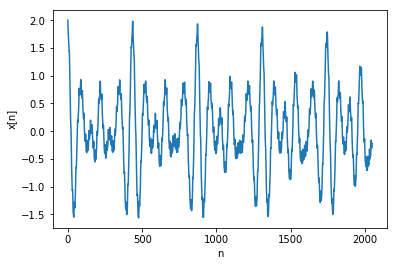

In [2]:
# Definindo as variaveis iniciais

fs = 48000

f0 = 440
f1 = 554
f2 = 660
f3 = 880
f4 = 4400
f5 = 8800

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05

# n variando de 0 a 2048
n = [i for i in range(2048)]
nfft = len(n)

# definindo as frequencias
freqmax = fs/2
freqmin = 0

freqhop = (freqmax - freqmin)/nfft

# o sinal de teste, x, eh um combinacao de cosenoides de diferentes periodos
x = np.multiply(A0, np.cos(np.multiply(2*(np.pi)*f0/fs, n))) + np.multiply(A1, np.cos(np.multiply(2*(np.pi)*f1/fs, n))) + np.multiply(A2, np.cos(np.multiply(2*(np.pi)*f2/fs, n))) + np.multiply(A3, np.cos(np.multiply(2*(np.pi)*f3/fs, n))) + np.multiply(A4, np.cos(np.multiply(2*(np.pi)*f4/fs, n))) + np.multiply(A5, np.cos(np.multiply(2*(np.pi)*f5/fs, n)))

plt.plot(n, x)
plt.ylabel('x[n]')
plt.xlabel('n')
plt.show()

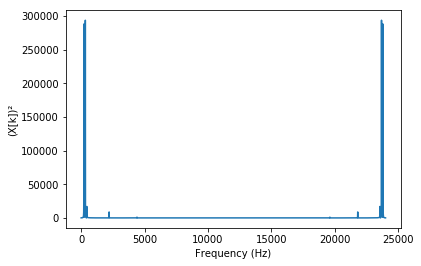

In [3]:
# realizamos a fft de x e avaliamos seus valores absolutos
x_fft = np.fft.fft(x);
x_fft_2 = np.power(abs(x_fft), 2)

freq = np.dot(n, freqhop)

plt.plot(freq, x_fft_2)
plt.ylabel('(X[k])²')
plt.xlabel('Frequency (Hz)')
plt.show()

In [4]:
# encontramos os picos da FFT
peaks, _ = signal.find_peaks(x_fft_2)


# definimos a funcao de transformacao do dominio da frequencia (FFT)
# para o dominio Bark (utilizamos a formula que parecia mais atualizada
# de acordo com os artigos recentes sobre o assunto)

def freq2bark(freq):

    bark = 6 * np.arcsinh(freq/600)
    
    return bark


# definimos a funcao de transformacao da escala linear para a
# escala SPL em dB

def amp2spl(x_fft_2):
    
    w_2 = 1
        
    SPL = 96 + np.dot(10, np.log10(np.dot((4 / ((nfft^2) * w_2)), x_fft_2)))
    
    return SPL

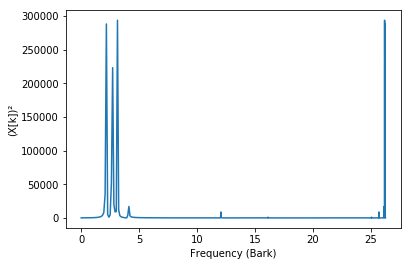

In [5]:
# realizamos a transformacao de dominios

bark = freq2bark(freq)

plt.plot(bark, x_fft_2)
plt.ylabel('(X[k])²')
plt.xlabel('Frequency (Bark)')
plt.show()

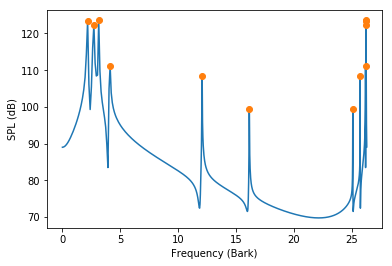

In [6]:
# e a transformacao de escalas

SPL = amp2spl(x_fft_2)

plt.plot(bark, SPL)
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()